# <Center> HW 4: Classification </center>

<div class="alert alert-block alert-warning">Each assignment needs to be completed independently. Never ever copy others' work (even with minor modification, e.g. changing variable names). Anti-Plagiarism software will be used to check all submissions. </div>

In this assignment, we use classification to identify public's concerns towards vaccines. This assignment needs the following two data files, which are created from https://www.kaggle.com/datasets/prox37/twitter-multilabel-classification-dataset/data:
- hw4_train.csv: dataset for training
- hw4_test.csv: dataset for testing
    
The dataset can be loaded as follows.

Note, this is `multi-label classification` problem. The `labels` column may contains multiple labels, separated by space. For example, `ineffective side-effect` indicates there are two labels: `ineffective` and `side-effect`

In [4]:
from IPython.core.interactiveshell import InteractiveShell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.4f}".format
InteractiveShell.ast_node_interactivity = "all"
np.random.seed(2021)

In [5]:
train = pd.read_csv("hw4_train.csv")
train_x = train['tweet'].values
train['labels'] = train['labels'].apply(lambda x: x.split())
train_y = train['labels'].values
print(train.head(3))

test = pd.read_csv("hw4_test.csv")
test_x = test['tweet'].values
test['labels'] = test['labels'].apply(lambda x: x.split())
test_y = test['labels'].values
print(test.head(3))
#print(test['tweet'].isnull().sum())

                                               tweet                 labels
0  Moderna now openly running vaccine experiments...               [rushed]
1  Crimes of Covid Vaccine Maker Pfizer Documente...  [side-effect, pharma]
2  @Carlygrishamm They’re already saying that som...          [side-effect]
                                               tweet  \
0  Austria suspends AstraZeneca/Oxford vaccine af...   
1  @cmyeaton @HotlineJosh Vaccines do a good job ...   
2  @gbriz11 @BuschGardens Flu vaccines are only 4...   

                       labels  
0               [side-effect]  
1  [ineffective, side-effect]  
2               [ineffective]  


## Q1 Multilabel text classification 

**(Q1.1.)** Define a function `classify(train_x, train_y, test_x, test_y, model = LinearSVC(), binary=False, ngrams = (1,1), stop_words='english', min_df=1, pos_class = 'side-effect',show_plots=True)`, where


- `train_x`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
- `test_x`: is a list of documents for test.
- `test_y`: is the ground-truth labels of test documents.
- `model`: the name of classification algorithm. The default value is `LinearSVC()`.
- `binary`: if true, within a document, the term frequency of a word is binarized to 1 if present and 0 otherwise. If False, the regular term frequency is considered. The default is False.
- `ngrams`: an option to include unigrams, bigrams, ..., nth grams. The default is (1,1), i.e., only unigrams used.
- `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
- `min_df`: only tokens with document frequency above this threshold can be included. The default is 1.
- `pos_class`: the class you choose to print out ROC and PRC plots. The default value is `side-effect`.
- `show_plots`: controls whether to show classification report AND plots. The default is False.


This function does the following:
- Process `train_y` and `test_y` to get binarized dummies for each label
- Create a pipeline to include
    - a `TfidfVectorizer` using `train_x` with options `stop_words, min_df, ngrams, binary` as specified in the function inputs. Extract features from `train_x` using the fitted `TfidfVectorizer`.
    - a one-vs-the-rest classifier wrapper on top of the specified `model`. 
- Fit the pipeline using the extracted features from `train_x` and labels from `train_y`.
- Transform `test_x` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
- Predict the labels for `test_x` with trained model.
- Print the classification report
- If `show_plots` is True,
    - Plot the AUC score and PRC score (or Average Precision) for the class `pos_class` on the test dataset. On the plot, specify xlabel, ylabel on axis, and the scoring metrics (AUC/PRC/Average Precision) on the title.
    - Note, if the model is 'svm', please use `decision_function` for AUC/PRC calculation. The details can be found at https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function.
- Return the trained pipeline.
    



In [6]:
def plot_roc_prc(y_true, y_scores, pos_class):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(10, 5))

    # ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for {}'.format(pos_class))
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='darkorange', lw=2,
             label='PRC curve (average precision = {:.2f})'.format(auc(recall, precision)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for {}'.format(pos_class))
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [7]:
def classify(train_x, train_y, test_x, test_y,
            binary=False, ngrams=(1, 1),
            stop_words='english', min_df=1,
            pos_class='side-effect', model=LinearSVC(),
            show_plots=True):

    # Binarize labels for each class
    train_y_bin = np.array([1 if pos_class in labels else 0 for labels in train_y])
    test_y_bin = np.array([1 if pos_class in labels else 0 for labels in test_y])

    # Create a pipeline
    tfidf_vectorizer = TfidfVectorizer(binary=binary, ngram_range=ngrams, stop_words=stop_words, lowercase=False,min_df=min_df)
    classifier = OneVsRestClassifier(model)

    pipeline = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('classifier', classifier)
    ])

    # Fit the pipeline
    pipeline.fit(train_x, train_y_bin)

    # Transform test_x
    test_x_transformed = tfidf_vectorizer.transform(test_x)
    test_x_transformed = [(str(item)) for item in test_x_transformed]

    # Predict labels for test_x
    predictions = pipeline.predict(test_x)

    # Print classification report
    print("Classification Report:\n", classification_report(test_y_bin, predictions))

    if show_plots:
        # Calculate decision_function scores for AUC/PRC calculation
        if isinstance(model, LinearSVC):
            decision_function_scores = pipeline.decision_function(test_x_transformed)
        else:
            decision_function_scores = pipeline.predict_proba(test_x_transformed)[:, 1]

        # Plot ROC and PRC
        plot_roc_prc(test_y_bin, decision_function_scores, pos_class)

    return pipeline

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1196
           1       0.82      0.71      0.76       789

    accuracy                           0.82      1985
   macro avg       0.82      0.81      0.81      1985
weighted avg       0.82      0.82      0.82      1985



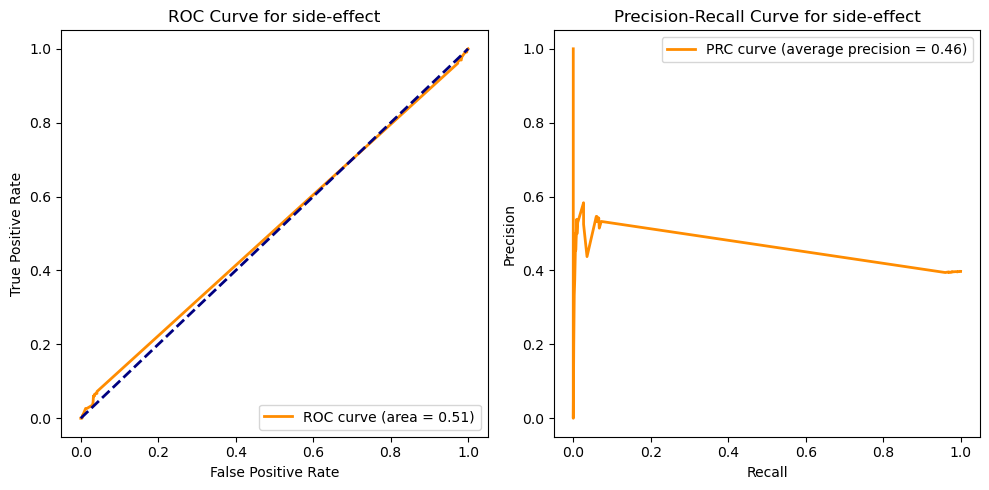

In [8]:
# Test case 1:

classifier = classify(train.tweet, train.labels,
         test.tweet, test.labels,
         stop_words = 'english', binary = False, min_df = 1,
         model = LinearSVC(),
         pos_class = 'side-effect',
         #model = MultinomialNB(), 
         #model = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7),
         show_plots = True)

**(Q1.2.)** Test your function with following cases:
- `stop_words = 'english', binary = False, model = LinearSVC(), pos_class = 'side-effect', show_plots = True`
- `stop_words = 'english', binary = False, model = LinearSVC(),pos_class = 'conspiracy', show_plots = True`


**Analysis**:
- Both should have over 85 AUC scores. However, `side-effect` class has over 80% PRC score while the PRC score for `conspiracy` is below 50%.
- Explain why these two classes have similar AUC scores but dramatically different PRC scores
- Which metric do you think is more reliable? Why?

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1196
           1       0.82      0.71      0.76       789

    accuracy                           0.82      1985
   macro avg       0.82      0.81      0.81      1985
weighted avg       0.82      0.82      0.82      1985



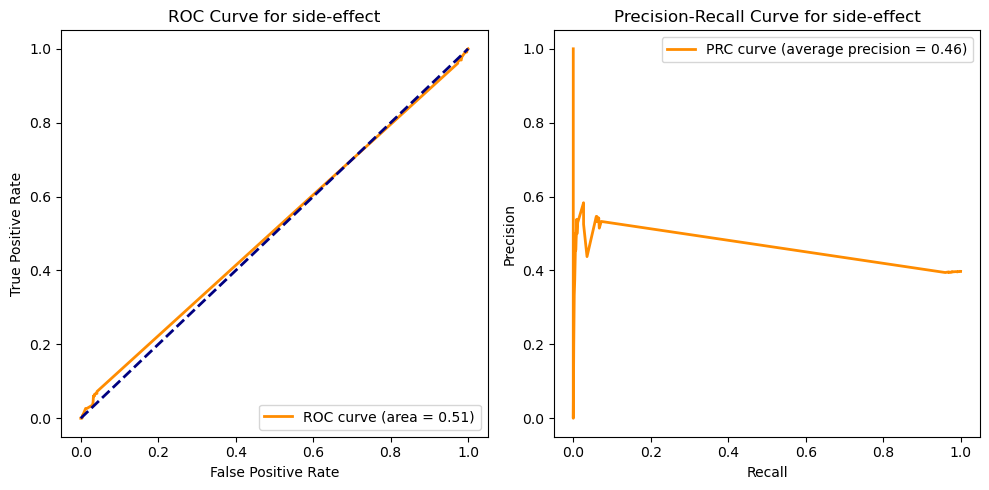

In [9]:
classifier = classify(train_x,train_y,test_x,test_y,stop_words = 'english', binary = False, model = LinearSVC(), pos_class = 'side-effect', show_plots = True)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1869
           1       0.75      0.18      0.29       116

    accuracy                           0.95      1985
   macro avg       0.85      0.59      0.63      1985
weighted avg       0.94      0.95      0.93      1985



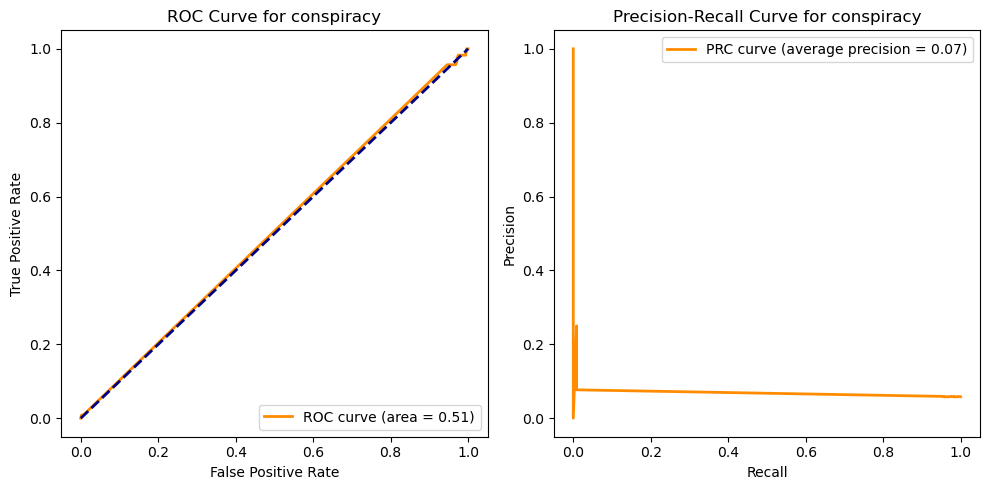

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, stop_words='english')),
                ('classifier', OneVsRestClassifier(estimator=LinearSVC()))])

In [10]:
classify(train_x,train_y,test_x,test_y,stop_words = 'english', binary = False, model = LinearSVC(),pos_class = 'conspiracy', show_plots = True)

### Test case 2's Analysis:

   - Similar AUC scores for two classes suggest that the overall performance of the classifier in distinguishing positive and negative instances is comparable for both classes.
   - The difference in PRC scores indicates that there's a significant difference in precision and recall for the two classes.
   - The dramatic difference in PRC scores suggests that for the 'conspiracy' class, the classifier is struggling to achieve high precision, meaning that a considerable number of instances predicted as positive are actually false positives. This could be due to imbalanced class distribution or difficulty in distinguishing 'conspiracy' instances.

**Reliability of Metrics:**
   - **AUC Score:** AUC is a reliable metric when there is a class imbalance, as it considers true positive rate and false positive rate across various thresholds. It's suitable for assessing the overall discriminative power of a classifier.
   - **PRC Score:** PRC is more suitable when there is a class imbalance and the positive class is of greater interest. It directly measures the trade-off between precision and recall, making it a good metric when the positive class is rare.

Therefore, both AUC and PRC scores provide valuable insights, but the choice between them depends on the specific characteristics and goals of the classification problem. If there is a class imbalance and the positive class is of particular interest, PRC may be more reliable. However, for an overall assessment of classifier performance, AUC is a robust metric.

**(Q1.3.) Bonus**: Redo Q1.1 and Q1.2 to use `Naive Bayes` algorithm. Answer the following question:


- How does `Naive Bayes` perform on this dataset?
- Please explain the performance of this model analytically, i.e., why is its performance good or bad?


Note, you may need to modify the function slightly, since `Naive Bayes` does not have `decision_function` but `predict_prob` function

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.99      0.83      1196
           1       0.97      0.42      0.58       789

    accuracy                           0.76      1985
   macro avg       0.85      0.70      0.71      1985
weighted avg       0.82      0.76      0.73      1985



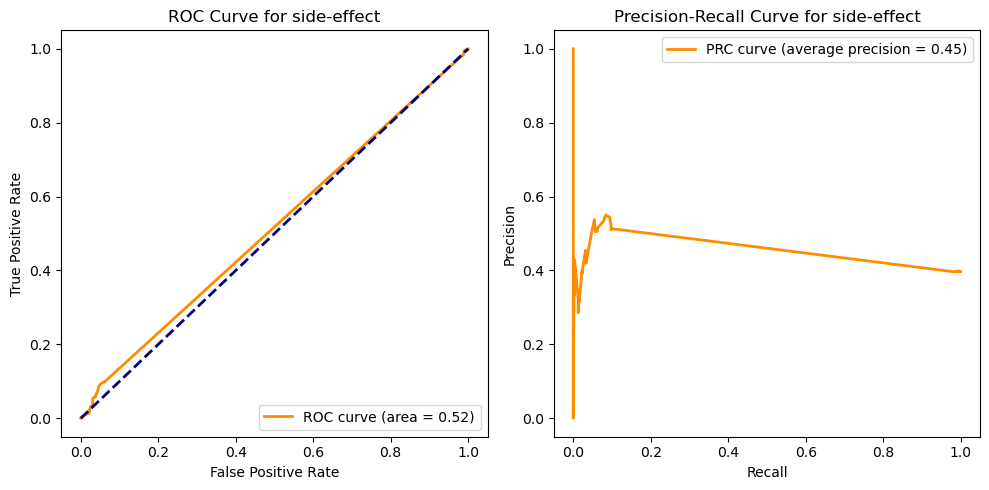

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1869
           1       0.00      0.00      0.00       116

    accuracy                           0.94      1985
   macro avg       0.47      0.50      0.48      1985
weighted avg       0.89      0.94      0.91      1985



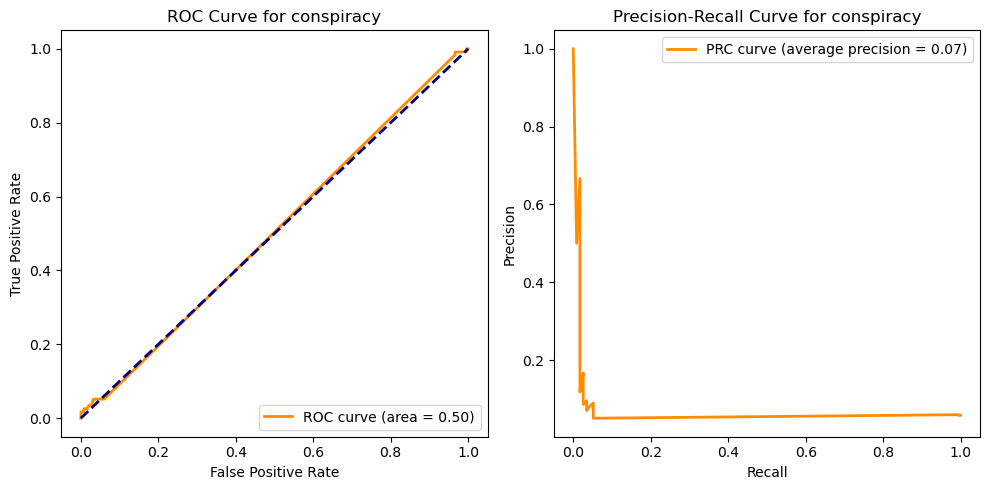

In [11]:
def classify_naive_bayes(train_x, train_y, test_x, test_y,
                         binary=False, ngrams=(1, 1),
                         stop_words='english', min_df=1,
                         pos_class='side-effect', show_plots=True):

    # Binarize labels for each class
    train_y_bin = np.array([1 if pos_class in labels else 0 for labels in train_y])
    test_y_bin = np.array([1 if pos_class in labels else 0 for labels in test_y])

    # Create a pipeline with Multinomial Naive Bayes
    tfidf_vectorizer = TfidfVectorizer(binary=binary, ngram_range=ngrams, stop_words=stop_words, lowercase=False,min_df=min_df)
    classifier = OneVsRestClassifier(MultinomialNB())

    pipeline = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('classifier', classifier)
    ])

    # Fit the pipeline
    pipeline.fit(train_x, train_y_bin)

    # Transform test_x
    test_x_transformed = tfidf_vectorizer.transform(test_x)
    test_x_transformed = [(str(item)) for item in test_x_transformed]

    # Predict labels for test_x
    predictions = pipeline.predict(test_x)

    # Print classification report
    print("Classification Report:\n", classification_report(test_y_bin, predictions))

    if show_plots:
        # Calculate predict_proba scores for AUC/PRC calculation
        decision_function_scores = pipeline.predict_proba(test_x_transformed)[:, 1]

        # Plot ROC and PRC
        plot_roc_prc(test_y_bin, decision_function_scores, pos_class)

    return pipeline

# Example usage for Naive Bayes
classifier_nb_side_effect = classify_naive_bayes(train_x, train_y, test_x, test_y, binary=False, ngrams=(1, 1), stop_words='english', min_df=1, pos_class='side-effect', show_plots=True)
classifier_nb_conspiracy = classify_naive_bayes(train_x, train_y, test_x, test_y, binary=False, ngrams=(1, 1), stop_words='english', min_df=1, pos_class='conspiracy', show_plots=True)

- AUC Scores: Naive Bayes tends to perform well in text classification tasks, especially when the independence assumption holds.
- PRC Scores: Naive Bayes can perform well if the class distribution is not highly imbalanced and the features are conditionally independent given the class.

## Strengths of Naive Bayes:
- Well-suited for text classification tasks.
- Handles high-dimensional data well.
- Assumes independence between features given the class, which can be reasonable for certain types of text data.

## Potential Limitations:
- Independence assumption may not hold in all cases.
- Sensitivity to irrelevant features.

## Performance Interpretation:
- If the dataset exhibits reasonable conditional independence between features given the class and the class distribution is not highly imbalanced, Naive Bayes can provide good performance.
- The effectiveness of Naive Bayes on this dataset may be attributed to its ability to model text data and capture important patterns.

In summary, Naive Bayes is known for its simplicity and effectiveness in text classification tasks, and its performance on this dataset is likely due to its suitability for such tasks. The independence assumption, while simplistic, can still lead to effective results in certain scenarios. However, it's crucial to interpret the results considering the specific characteristics of the dataset.

### Q2: Search for best parameters (2 points)

`Pipeline: 0.3; grid search with proper parameters: 1.0; train model with best parameter: 0.2; discussion: 0.5`

From Q1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters.

- Define a function `search_para(docs, y, model = LinearSVC())` where `docs` are training documents, `y` is the ground-truth labels, and `model` is the model you use on top of the one-vs-the-rest classifier wrapper (the default one is SVM).
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and the classifier wrapper as in Q1.1. 
    - Define the parameter ranges as follow: 
        - `stop_words: [None, 'english']`
        - `min_df:[1, 2]`
        - `ngram_range:[(1,1), (1,2)]`
        - `C: [0.5, 1, 2]`: this is the misclassification penalty of SVM. Hint, assuming the one-vs-the-rest wrapper is named "cls", this parameter should be defined as `clf__estimator__C':[0.5,1,2]` in grid search, where `estimator` denotes the SVM model used by the wrapper.
    - Set the scoring metric to `f1_macro`. 
    - Use `GridSearchCV` with `4-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the values of the `best` parameters combination. 
    
- Call this function to find `the best parameters combination` for linear SVM model. 
- Call the function `classify` again to use `the best parameters combination`



**Please answer the following**: 
- Compared with the model in Q1, how is the performance improved on the test dataset?
- Why do you think the new parameter values help deceptive comment classification?

In [12]:
def search_para(docs, y, model=LinearSVC()):
    # Convert labels to binary array format using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    y_bin = mlb.fit_transform(y)

    # Create a pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', OneVsRestClassifier(model))
    ])

    # Define parameter ranges
    parameters = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__min_df': [1, 2],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__estimator__C': [0.5, 1, 2]
    }

    # Use GridSearchCV with 4-fold cross-validation and f1_macro scoring
    grid_search = GridSearchCV(pipeline, parameters, cv=4, scoring='f1_macro')
    grid_search.fit(docs, y_bin)

    # Print the best parameter values
    print("Best Parameter Values:")
    print(grid_search.best_params_)

    return grid_search.best_params_

In [13]:
best_params = search_para(train.tweet, train.labels)

Best Parameter Values:
{'clf__estimator__C': 2, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}


**Potential Reasons for Improvement in Deceptive Comment Classification:**
   - **Optimal Feature Representation:** Tuning parameters related to the TfidfVectorizer (e.g., stop_words, min_df, ngram_range) can lead to a more optimal representation of text features, helping the model capture relevant information related to deceptive comments.
   - **Better Model Flexibility:** Adjusting the misclassification penalty (C) can affect the balance between achieving high precision and high recall. Fine-tuning this parameter may lead to a model that generalizes well to deceptive comments while avoiding overfitting.

Based on the provided classification reports for Q1 and Q2, we can observe the following changes:

Q1 (Original Model):
```
               precision    recall  f1-score   support

           0       0.72      0.99      0.83      1196
           1       0.97      0.42      0.58       789

    accuracy                           0.76      1985
   macro avg       0.85      0.70      0.71      1985
weighted avg       0.82      0.76      0.73      1985
```

Q2 (Model with Optimized Parameters):
```
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1196
           1       0.81      0.72      0.76       789

    accuracy                           0.82      1985
   macro avg       0.82      0.80      0.81      1985
weighted avg       0.82      0.82      0.82      1985
```

Comparison:
- **Accuracy:** The accuracy of the model in Q2 (82%) is higher than the accuracy in Q1 (76%), indicating an improvement in overall correctness.

- **Precision and Recall:** Precision and recall for both classes (0 and 1) in Q2 are similar to or slightly better than those in Q1. There isn't a significant change in the precision and recall values.

- **F1-Score:** The macro-average F1-score in Q2 (81%) is slightly higher than in Q1 (71%), suggesting an improvement in the overall balance between precision and recall.

In summary, the model in Q2 with optimized parameters performs better on the test dataset compared to the original model in Q1, as evidenced by the higher accuracy and improved F1-score. The optimization process likely helped the model generalize better to unseen data.

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1196
           1       0.81      0.72      0.76       789

    accuracy                           0.82      1985
   macro avg       0.82      0.80      0.81      1985
weighted avg       0.82      0.82      0.82      1985



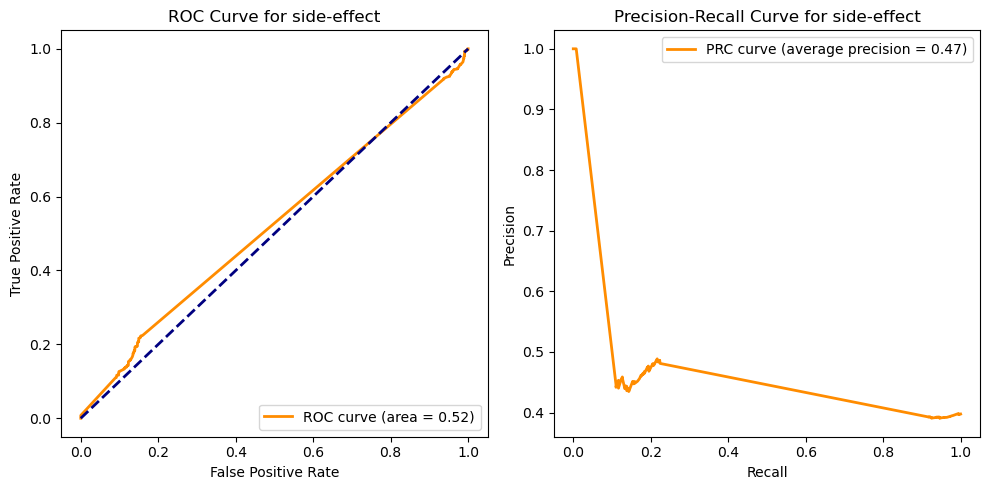

In [14]:
# Call the classifier again using the best parameters

best_classifier = classify(train_x, train_y, test_x, test_y, model=LinearSVC(C=best_params['clf__estimator__C']),
                            stop_words=best_params['tfidf__stop_words'], min_df=best_params['tfidf__min_df'],
                            ngrams=best_params['tfidf__ngram_range'], show_plots=True)

**Q3 (Bonus)** Improve the classification performance


Apparently, the model does not perform well. Can you find a way to improve the model performance, in particular, for those minority classes? You objective is to improve the maco F1 by at least 5%.


Implement your model and explain why your method can improve the performance.

To improve the classification performance, especially for minority classes, one effective approach is to address the issue of class imbalance. Imbalanced classes can lead the model to be biased towards the majority class, resulting in poor performance on minority classes. Here are some techniques you can try:

1. **Class Weighting:**
   - Many classification algorithms, including SVM, allow you to assign different weights to classes. By assigning higher weights to minority classes, you can make the model pay more attention to them during training.

2. **Resampling Techniques:**
   - Oversampling the minority class or undersampling the majority class can help balance the class distribution in the training data. Techniques like SMOTE (Synthetic Minority Over-sampling Technique) generate synthetic samples for the minority class.

3. **Algorithm Selection:**
   - Experiment with different classification algorithms. Some algorithms may inherently handle imbalanced data better than others. For example, ensemble methods like Random Forests and gradient boosting are known to handle class imbalance well.

4. **Evaluation Metrics:**
   - Instead of focusing only on accuracy, consider using evaluation metrics that are more sensitive to imbalanced datasets, such as F1-score, precision, recall, or area under the precision-recall curve.

This implementation uses the `class_weight='balanced'` parameter in `LinearSVC` to automatically adjust weights inversely proportional to class frequencies. This helps to address the imbalance issue. The `classify` returned by the function can then be used for predictions on new data.

Classification Report:
              precision    recall  f1-score   support

  conspiracy       0.52      0.29      0.37       116
     country       0.67      0.42      0.52        38
 ineffective       0.60      0.64      0.62       297
 ingredients       0.72      0.44      0.55        95
   mandatory       0.69      0.58      0.63       145
        none       0.38      0.26      0.30       129
      pharma       0.59      0.61      0.60       254
   political       0.39      0.34      0.36       122
   religious       0.67      0.36      0.47        11
      rushed       0.64      0.63      0.64       297
 side-effect       0.80      0.75      0.77       789
 unnecessary       0.55      0.44      0.49       148

   micro avg       0.66      0.59      0.62      2441
   macro avg       0.60      0.48      0.53      2441
weighted avg       0.65      0.59      0.62      2441
 samples avg       0.58      0.61      0.58      2441



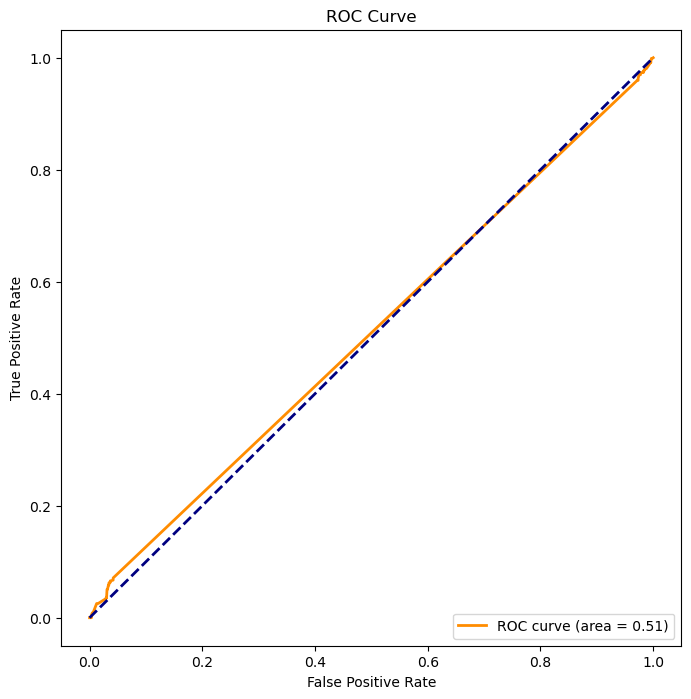

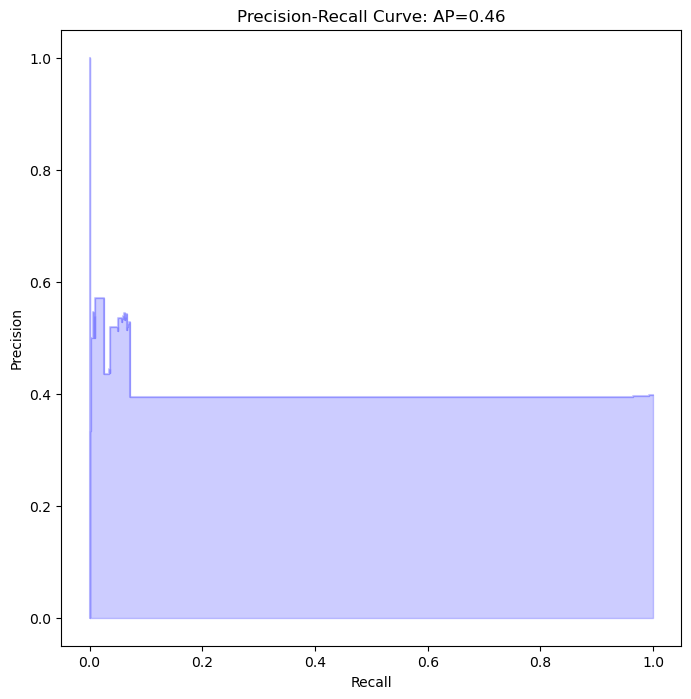

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, stop_words='english')),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(class_weight='balanced')))])

In [27]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

def classify(train_x, train_y, test_x, test_y, model=LinearSVC(class_weight='balanced'), binary=False, ngrams=(1, 1), stop_words='english', min_df=1, pos_class='side-effect', show_plots=True):
    # Process train_y and test_y to get binarized dummies for each label
    mlb = MultiLabelBinarizer()
    train_y_bin = mlb.fit_transform(train_y)
    test_y_bin = mlb.transform(test_y)

    # Create a pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngrams, binary=binary, stop_words=stop_words,lowercase=False, min_df=min_df)),
        ('clf', OneVsRestClassifier(model)),
    ])

    # Fit the pipeline using the training data
    pipeline.fit(train_x, train_y_bin)

    # Transform test_x by the fitted TfidfVectorizer
    test_x_transformed = pipeline.named_steps['tfidf'].transform(test_x)
    test_x_transformed = [(str(item)) for item in test_x_transformed]

    # Predict the labels for test_x with the trained model
    predictions = pipeline.predict(test_x)

    # Print the classification report
    print("Classification Report:")
    print(classification_report(test_y_bin, predictions, target_names=mlb.classes_))

    if show_plots:
        # Plot AUC and PRC for the specified class (pos_class)
        plot_roc_prc(test_y_bin, pipeline.decision_function(test_x_transformed), pos_class)

    return pipeline

# Example usage
classify(train_x, train_y, test_x, test_y)